In [24]:
import laspy
import open3d as o3d
import numpy as np
from matplotlib import pyplot as plt
from math import ceil, floor, fabs
from scipy.signal import savgol_filter, find_peaks

### LAS file formatting
---

In [3]:
input_las = laspy.read('/home/thomas/aarc-repos/lidar_roof_generator/test_clouds/small_bldgs.las')
input_las

<LasData(1.4, point fmt: <PointFormat(6, 0 bytes of extra dims)>, 1411906 points, 2 vlrs)>

Getting info from the header file

In [4]:
input_las.header.z_min

82.75

Creating a new LAS file with the same format as our input Las file.

In [5]:
buildings_lidar = laspy.create(point_format = input_las.header.point_format, file_version = input_las.header.version)
buildings_lidar


<LasData(1.4, point fmt: <PointFormat(6, 0 bytes of extra dims)>, 0 points, 0 vlrs)>

Filtering the buildings classification (6) into the newly created Las file

In [6]:
buildings_lidar.points = input_las.points[input_las.classification == 6]
buildings_lidar.header.z_min

84.41

Writing the new buildings lidar file to new las file

In [7]:
#buildings_lidar.write('/home/thomas/aarc-repos/lidar_roof_generator/test_clouds/buildings.las')

Converting the buildings lidar to a Numpy 3d array

*NOTE: CONVERTING TO NUMPY 3D ARRAY CONVERTS TO CM. NEED TO ENSURE YOU HAVE METERS. HENCE THE DIVIDE BY 100 BELOW*

In [8]:
buildings_points = np.stack([buildings_lidar.X /100, buildings_lidar.Y /100, buildings_lidar.Z /100], axis= 0).transpose((1,0))
buildings_points

array([[365.48, 159.77, 104.09],
       [366.8 , 159.64, 101.53],
       [365.2 , 159.81, 103.61],
       ...,
       [298.83, 200.  , 102.64],
       [334.87, 200.  , 105.6 ],
       [310.27, 200.  , 102.28]])

### Site cloud cleaning and processing

---

In [20]:
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(buildings_points)
o3d.visualization.draw_geometries([geom])

The LAS file after being sorted by ASPR classification:

![ASPR CLassification](data/images/01-site.png)

Converting Numpy array to Open3D pointcloud

In [10]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(buildings_points)
pcd

PointCloud with 635633 points.

Computing point cloud normals - See [this link](http://www.open3d.org/docs/0.9.0/tutorial/Basic/pointcloud.html#vertex-normal-estimation)

In [11]:
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=10, max_nn=100))
# KDtree parameters, radius 1 = 1m, max_nn means neighbours to be considered for normal calc

o3d.visualization.draw_geometries([pcd])

Pointcloud normals back to numpy

In [12]:
normals_z = np.absolute(np.asarray(pcd.normals)[:,2])
normals_z

array([0.39263132, 0.75299184, 0.06093856, ..., 0.89400803, 0.94118862,
       0.99984255])

Filtering Points based on normal z-value

In [21]:
#creating a bit mask on numpy
vert_tolerance = 0.1
vert_bitmask = np.greater(normals_z, vert_tolerance)

#applying bitmask
filtered_pts = buildings_points[vert_bitmask]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(filtered_pts)
o3d.visualization.draw_geometries([pcd])


Vertical removed based on normals. Noise is cleaned in next step.

![Remove walls](data/images/02-vertical%20removed.png)

Statistical Outlier Removal

In [14]:
clean_cloud, ix = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=3.0) #remove noise
clean_pts = np.asarray(clean_cloud.points).copy() #MAKE SURE YOU MAKE A COPY


### Sitecloud clustering
---

In [15]:
from random import random
flat_pts = np.asarray(pcd.points)
flat_pts[:,2] = 0

#creating the new cloud from the flat points
flat_cloud = o3d.geometry.PointCloud()
flat_cloud.points = o3d.utility.Vector3dVector(flat_pts)

clusters = np.asarray(flat_cloud.cluster_dbscan(1.5, 20)) #the assigned cluster by point - PARAMETERS ARE DENSITY AND NUM OF POINTS. SO 1,10 IS A MIN. DENSITY OF 10PTS/SQ.M
#really in the above, the main parameter that matters is the first one. It more or less defines the gap between buildings.
cluster_labels = np.unique(clusters) # the unique cluster labels

In [22]:
pt_clouds=[]
clustered_bldg_pts = []

for label in cluster_labels:
    cluster_cloud = o3d.geometry.PointCloud()
    cluster_pts = filtered_pts[clusters == label]
    clustered_bldg_pts.append(cluster_pts)

    cluster_cloud.points = o3d.utility.Vector3dVector(cluster_pts)
    cluster_cloud.paint_uniform_color([random(), random(), random()])
    pt_clouds.append(cluster_cloud)


o3d.visualization.draw_geometries(pt_clouds)

Buildings are clustered in plan.

![clustering](data/images/03-clustering.png)

### Vertical binning function per building
___

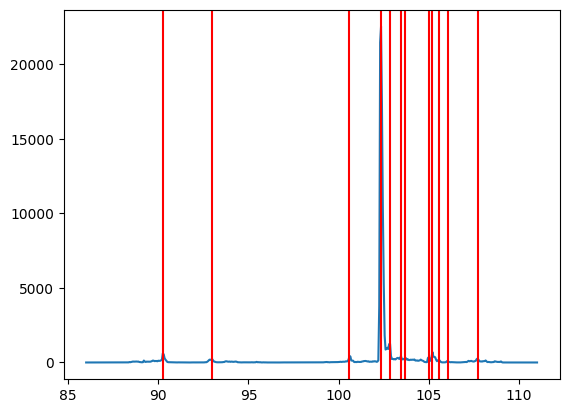

In [17]:
test_cloud = clustered_bldg_pts[3]
test_cloud_z = test_cloud[:,2]

max_elev = ceil(np.max(test_cloud_z))
min_elev = floor(np.min(test_cloud_z))

# create a range of numbers for binning every 5 cm
elev_bins = np.arange(min_elev, max_elev + 0.05, 0.05)

#bin the z values
bin_indices = np.digitize(test_cloud_z, elev_bins)

#how many values captured in each bin?
count_per_bin = np.zeros_like(elev_bins, dtype=int)
for index in bin_indices:
    count_per_bin[index] = count_per_bin[index] + 1

#filtering the data with savgol
filter_variance = savgol_filter(count_per_bin,10,3)

#finding the peaks indices
roof_levels = find_peaks(count_per_bin, prominence=100)[0]

#finding the peaks
peak_elevations = np.asarray([elev_bins[x] for x in roof_levels])

#the below plot shows how many points per level
plt.plot(elev_bins, count_per_bin)

for index in roof_levels:
    plt.axvline(x=elev_bins[index], color= 'red')

In [23]:
#finding the closest peak level for each point AND index of peak level - see: https://stackoverflow.com/a/2566508
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or fabs(value - array[idx-1]) < fabs(value - array[idx])):
        return array[idx-1], idx-1
    else:
        return array[idx], idx

elev_index = np.empty_like(test_cloud_z, dtype=int)
#replacing the z values with the peak values and recording index of peak value
for i in range(len(test_cloud)):
    nearest_peak_elev, nearest_peak_ix = find_nearest(peak_elevations, test_cloud_z[i])
    test_cloud[i,2] = nearest_peak_elev
    elev_index[i] = nearest_peak_ix

#splitting horizontal surfaces up by index
unique_elev_indices = np.unique(elev_index)

#masks per level
roof_masks=[]
for index in unique_elev_indices:
    roof_mask = (elev_index == index)*1
    roof_masks.append(roof_mask)


#cumulative masks to bring all points above down to certain level
merged_levels = []
merged_clouds_merged = []
for index in unique_elev_indices:
    base_array = np.zeros_like(roof_masks[0], dtype=int)
    
    for mask in roof_masks[index:]:
        base_array = np.add(base_array, mask)
    
    cumulative_mask = (base_array > 0)

    flattened_level = test_cloud[cumulative_mask]
    flattened_level[:,2] = peak_elevations[index]


    test_cloud_merged = o3d.geometry.PointCloud()
    test_cloud_merged.points = o3d.utility.Vector3dVector(flattened_level)

    test_cloud_merged.paint_uniform_color([random(), random(), random()])
    merged_clouds_merged.append(test_cloud_merged)

    merged_levels.append(flattened_level)

o3d.visualization.draw_geometries(merged_clouds_merged)

Building is clustered in elevation. Ready for tracing

![elevation clustering](data/images/04-vertical%20binning.png)